<img src='./img/logoline_12000.png' align='center' width='100%'></img>

<br>

# Analysing climate extremes


### About

This notebook provides you an introduction of analysing climate extremes. The case study focuses on daily maximum near-surface air temperature in the city of Lille in Northern France, which was affected by a heatwave in September 2020.

The first section [1 - Data preparation](#data_preparation) is mandatory, as it loads and prepares the dataset for the following parts. Section 2 to 4 guide you through different examples of analysing climate extremes.

The notebook has the following outline:
* [1 - Data preparation](#read_data)
* [2 - Visualize daily maximum 2m air temperature in Lille for September 2020](#temp_max)
* [3 - Calculation of the long term average of daily maximum near-surface air temperature over northern France for September](#longterm_averages)
* [4 - Analyse probability distributions of daily maximum 2m air temperature](#probability_distributions)

### Data

This notebook introduces you to the ERA5 reanalysis hourly data on single levels. The data has the following specifications:

> **Data**: `ERA5 hourly data on single levels` <br>
> **Temporal coverage**: `September 1979 to 2020` <br>
> **Spatial coverage**: `Area around Lille, northern France [N:51, E:3, S:50, W:4]` <br>
> **Format**: `NetCDF`<br>
> **Retrieve request**: [CDS API request](./100_climate_data_store_intro.ipynb#era5_monthly)

Get [here](./101_c3s_data_intro.ipynb) more information about climate reanalysis data in general including an overview of the different dataset types.

### Further resources

* [Heatwave shatters September records in western Europe](https://www.euronews.com/2020/09/16/heatwave-shatters-september-records-in-western-europe)

<hr>

### Load libraries

In [3]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# to suppress SSL warnings
import urllib3
urllib3.disable_warnings()

<hr>

## <a id='data_preparation'></a>1. Data preparation


The example below will show you different aspects on how to analyse climate extremes, based on an example of high temperature in Lille in September 2020.

### Load the dataset

The first step is to open the dataset with the function `open_dataset()` of the Python library [xarray](http://xarray.pydata.org/en/stable/). xarray is a Python library that makes the handling of multi-dimensional meteorological and climate data as well as `netCDF` data very efficient. The data file is available under the path: `./data/era5_t2m_hourly_northern_france_sep.nc`. 

The `open_dataset()` function returns a `xarray.Dataset` object, which can hold one or more `xarray.DataArray` objects, which are aligned on the same dimensions. The loaded `xarray.Dataset` has the following specifications: 
* three dimensions: `latitude`, `longitude` and `time` and
* 1 data variable: `t2m`

In [1]:
file = './data/era5_t2m_hourly_northern_france_sep.nc'

In [4]:
era5_t2m_hourly_ds = xr.open_dataset(file)
era5_t2m_hourly_ds

<xarray.Dataset>
Dimensions:    (longitude: 5, latitude: 5, time: 30240)
Coordinates:
  * longitude  (longitude) float32 3.0 3.25 3.5 3.75 4.0
  * latitude   (latitude) float32 51.0 50.75 50.5 50.25 50.0
  * time       (time) datetime64[ns] 1979-09-01 ... 2020-09-30T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-09-21 13:29:28 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

<br>

The next step is to load the data variable `t2m` as `xarray.DataArray` object. You can load a data variable from an `xarray.Dataset` by specifying the name of the data variable (`t2m`) in square brackets `[]`. A `xarray.DataArray` object is a labeled, multi-dimensional array, which you can modify and apply operations on. Below, you see additional `attributes` of the data variable, such as `units` and `long_name`.

In [5]:
era5_t2m_hourly_da = era5_t2m_hourly_ds['t2m']
era5_t2m_hourly_da

<xarray.DataArray 't2m' (time: 30240, latitude: 5, longitude: 5)>
[756000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 3.0 3.25 3.5 3.75 4.0
  * latitude   (latitude) float32 51.0 50.75 50.5 50.25 50.0
  * time       (time) datetime64[ns] 1979-09-01 ... 2020-09-30T23:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

<br>

Above, you see that the ERA-5 temperature data are per default in `Kelvin`, the base unit for temperature in the International System of Units (SI). If you want to convert the values from `Kelvin` to `degrees Celsius`, the formula is simple: 
> `degrees Celsius = Kelvin - 273.15`

In [6]:
era5_t2m_hourly_degc = era5_t2m_hourly_da - 273.15
era5_t2m_hourly_degc

<xarray.DataArray 't2m' (time: 30240, latitude: 5, longitude: 5)>
array([[[16.688995 , 16.261627 , 15.913879 , 15.6362915, 16.374664 ],
        [16.933228 , 16.616974 , 16.654175 , 17.03482  , 16.490082 ],
        [16.943237 , 16.503448 , 16.269257 , 16.306458 , 15.826111 ],
        [16.769135 , 16.57022  , 16.292633 , 15.89624  , 16.222504 ],
        [16.808258 , 16.406158 , 16.026947 , 15.662048 , 15.763641 ]],

       [[16.670868 , 16.332703 , 15.914856 , 15.448364 , 16.282135 ],
        [16.713806 , 16.559265 , 16.069397 , 15.405426 , 15.153107 ],
        [16.668976 , 16.407104 , 15.989258 , 15.440247 , 15.360107 ],
        [16.453857 , 16.149536 , 15.754578 , 15.42688  , 15.069153 ],
        [16.793945 , 16.326965 , 15.786072 , 15.391602 , 15.034332 ]],

       [[16.289764 , 15.9496765, 15.613861 , 15.264221 , 15.74646  ],
        [16.172424 , 16.174316 , 15.70163  , 14.979004 , 14.723328 ],
        [16.295471 , 16.1958   , 15.735016 , 15.066772 , 14.8463745],
        [16.414734 , 16.236816 , 15.760315 , 15.035767 , 14.574982 ],
        [16.57071  , 16.201508 , 15.687805 , 15.018097 , 14.525848 ]],

       ...,

       [[16.292633 , 16.19101  , 16.13092  , 16.081787 , 16.042694 ],
        [16.216766 , 16.12091  , 15.985931 , 15.808472 , 15.650116 ],
        [15.999756 , 16.026947 , 15.810394 , 15.523224 , 15.310486 ],
        [15.722626 , 15.7283325, 15.50177  , 15.1111145, 14.745758 ],
        [15.535156 , 15.480316 , 15.285217 , 14.933197 , 14.52536  ]],

       [[16.189117 , 16.101349 , 16.046509 , 16.00357  , 15.939178 ],
        [16.163849 , 16.138092 , 16.026947 , 15.857117 , 15.673492 ],
        [15.90387  , 16.165741 , 16.038849 , 15.76889  , 15.49176  ],
        [15.739777 , 15.880493 , 15.747437 , 15.390167 , 14.942749 ],
        [15.653931 , 15.652039 , 15.434998 , 15.095367 , 14.610748 ]],

       [[15.845673 , 15.7951355, 15.900543 , 16.07608  , 16.043152 ],
        [15.793213 , 15.870972 , 15.91629  , 15.939636 , 15.7812805],
        [15.656311 , 15.964935 , 15.931549 , 15.79895  , 15.538971 ],
        [15.463135 , 15.706879 , 15.662048 , 15.39444  , 14.912201 ],
        [15.234192 , 15.445496 , 15.345795 , 15.082031 , 14.550659 ]]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 3.0 3.25 3.5 3.75 4.0
  * latitude   (latitude) float32 51.0 50.75 50.5 50.25 50.0
  * time       (time) datetime64[ns] 1979-09-01 ... 2020-09-30T23:00:00

<br>

As a final step in the data preparation part, we want to average the near-surface air temperature values across the geographical domain. We can do this by applying the function `mean()` across both dimensions, `latitude` and `longitude` respectively. The resulting data array `era5_t2m_hourly_lille` has only the dimension `time` left. 

**Note:** Through the averaging across the two geographic dimensions, the data array has lost its attributes. Before visualizing the time-series data, we can re-assign the attributes, as it is always a good practice to take additional metadata forward. 

In [9]:
era5_t2m_hourly_lille = era5_t2m_hourly_degc.mean(["longitude", "latitude"])
era5_t2m_hourly_lille

<xarray.DataArray 't2m' (time: 30240)>
array([16.354841, 15.944101, 15.631228, ..., 15.670436, 15.746242,
       15.625982], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-09-01 ... 2020-09-30T23:00:00

<br>

Above, you see that when you convert the data values, the data array's `Attributes` are dropped. However, we want to keep the information provided by the `Attributes` and for this reason, we re-assign the attributes from the `era5_t2m_hourly_da` object with the function `assign_attrs()`. Since the unit has changed, we assign a new unit measure to the `units` attribute.

In [10]:
era5_t2m_hourly_lille = era5_t2m_hourly_lille.assign_attrs(era5_t2m_hourly_da.attrs)
era5_t2m_hourly_lille.attrs['units'] = '° C'
era5_t2m_hourly_lille

<xarray.DataArray 't2m' (time: 30240)>
array([16.354841, 15.944101, 15.631228, ..., 15.670436, 15.746242,
       15.625982], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-09-01 ... 2020-09-30T23:00:00
Attributes:
    units:      ° C
    long_name:  2 metre temperature

Now, the DataArray object `era5_t2m_hourly_lille` is in a format which allows us to proceed to visualize the daily maximum 2m air temperature in Lille for September 2020. 

<br>

## <a id='temp_max'></a>2. Visualize daily maximum 2m air temperature in Lille for September 2020


In September 2020, a record-breaking heatwave occured in large parts of western Europe. The city Lille in northern France for example experienced its hottest day in September 2020 since records began in 1945. As a next step, let us visualize the daily maximum 2m air temperature for September 2020. From the graph, we should be able to identify which day in September was hottest in Lille.

Let us select only the values for September 2020, as we interested in analysing the maximum temperature of each day in September 2020. You can use the function `sel()`, which allows you to filter dimensions based on labels. You can simply specify `time=2020` and the resulting data array `era5_t2m_hourly_lille_2020` holds hourly 2m air temperature for September 2020.

In [11]:
era5_t2m_hourly_lille_2020 = era5_t2m_hourly_lille.sel(time='2020')
era5_t2m_hourly_lille_2020

<xarray.DataArray 't2m' (time: 720)>
array([11.994373 , 11.635942 , 11.58538  , 11.410805 , 11.185704 ,
       10.983403 , 11.114991 , 12.538196 , 14.0212345, 15.738954 ,
       16.988302 , 17.736431 , 17.900898 , 18.130827 , 18.077248 ,
       18.151928 , 17.739006 , 17.288443 , 16.22449  , 14.484676 ,
       13.596997 , 12.729966 , 11.817196 , 11.494944 , 11.118216 ,
       10.587062 , 10.010896 ,  9.553385 ,  9.352591 ,  9.303462 ,
        9.762973 , 12.487733 , 14.483817 , 16.098066 , 17.335016 ,
       18.143265 , 18.629564 , 19.15471  , 19.270756 , 19.487503 ,
       19.38323  , 18.909578 , 17.63451  , 15.639165 , 14.449573 ,
       13.531956 , 13.098546 , 13.042072 , 13.448845 , 13.989659 ,
       14.219509 , 14.315386 , 14.585436 , 15.006352 , 15.203137 ,
       15.846426 , 16.804604 , 17.897348 , 18.732443 , 19.90515  ,
       21.09789  , 21.59917  , 21.446594 , 21.789146 , 21.65916  ,
       21.535751 , 21.11898  , 20.474201 , 20.197111 , 19.906815 ,
       19.66414  , 19.68154  , 19.2673   , 18.805424 , 18.534151 ,
       18.319008 , 18.179441 , 17.962774 , 17.859041 , 18.028465 ,
       18.549566 , 19.189037 , 19.20268  , 19.530521 , 20.03323  ,
       20.461613 , 20.71159  , 20.78016  , 20.68959  , 20.085016 ,
       19.065912 , 17.642807 , 16.958347 , 15.886724 , 16.08063  ,
       15.949818 , 15.806799 , 15.376645 , 15.193312 , 14.8843565,
...
       11.887088 , 11.873065 , 11.950637 , 12.290201 , 12.892867 ,
       13.462031 , 14.064507 , 14.49101  , 14.810426 , 15.520873 ,
       15.596213 , 15.623405 , 15.587574 , 15.416621 , 15.122128 ,
       14.665514 , 14.125143 , 13.602879 , 13.122052 , 12.810769 ,
       12.839368 , 12.655462 , 12.551819 , 12.469721 , 12.326681 ,
       12.403667 , 12.406033 , 12.411681 , 12.509865 , 12.650806 ,
       12.5519705, 12.621748 , 12.863791 , 13.497329 , 13.734393 ,
       13.791608 , 13.587688 , 13.405745 , 13.303441 , 13.1544285,
       13.258031 , 13.391094 , 13.385427 , 13.242235 , 13.124739 ,
       12.728059 , 12.334233 , 11.772723 , 11.622226 , 11.229335 ,
       11.176297 , 10.91786  , 10.562905 , 10.535221 , 11.577157 ,
       13.268123 , 14.559584 , 15.184879 , 15.819754 , 16.344442 ,
       16.997728 , 17.471529 , 17.858238 , 17.638382 , 16.824577 ,
       15.791901 , 15.237676 , 14.878635 , 14.246964 , 14.078548 ,
       13.856538 , 13.48922  , 13.403417 , 13.3804455, 13.277496 ,
       13.464949 , 13.676792 , 13.840723 , 14.209797 , 14.765458 ,
       15.395729 , 16.387104 , 17.227768 , 17.578568 , 17.705048 ,
       17.439747 , 17.382679 , 17.387352 , 16.658436 , 16.154829 ,
       15.7532015, 15.752139 , 15.670436 , 15.746242 , 15.625982 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2020-09-01 ... 2020-09-30T23:00:00
Attributes:
    units:      ° C
    long_name:  2 metre temperature

<br>

Based on the hourly 2m air temperature values for September 2020, we can now select the maximum temperature for each day. You can apply the function `groupby('time.day')`, which first groups the data by days. Afterwards, we can apply the function `max()` in order to select the maximum value for each group.

The resulting data array `era5_t2m_max_2020_lille` has the dimension `day` and holds for each day the maximum temperature value.

In [12]:
era5_t2m_max_2020_lille = era5_t2m_hourly_lille_2020.groupby('time.day').max()
era5_t2m_max_2020_lille

<xarray.DataArray 't2m' (day: 30)>
array([18.151928, 19.487503, 21.789146, 20.78016 , 18.702335, 18.761843,
       20.953974, 20.834309, 23.93709 , 21.671236, 22.653204, 21.199112,
       24.5667  , 30.843462, 32.05613 , 26.875269, 20.375631, 24.347378,
       26.045216, 25.168676, 23.634314, 23.292368, 20.424883, 15.962259,
       10.837861, 12.182823, 15.623405, 13.791608, 17.858238, 17.705048],
      dtype=float32)
Coordinates:
  * day      (day) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30

<br>

Before we visualize the daily maximum 2m air temperature values for Lille in September 2020, let us assign the lost attributes to the data array. In this way, we can take forward the additional metadata and make use of them in the visualization.

We can use the function `assign_attrs()` to assign attributes to an `xarray.DataArray`.

In [13]:
era5_t2m_max_2020_lille = era5_t2m_max_2020_lille.assign_attrs(era5_t2m_hourly_degc.attrs)
era5_t2m_max_2020_lille.attrs['long_name'] = 'Daily maximum near-surface air temperature - September 2020 - Lille, France'
era5_t2m_max_2020_lille

<xarray.DataArray 't2m' (day: 30)>
array([18.151928, 19.487503, 21.789146, 20.78016 , 18.702335, 18.761843,
       20.953974, 20.834309, 23.93709 , 21.671236, 22.653204, 21.199112,
       24.5667  , 30.843462, 32.05613 , 26.875269, 20.375631, 24.347378,
       26.045216, 25.168676, 23.634314, 23.292368, 20.424883, 15.962259,
       10.837861, 12.182823, 15.623405, 13.791608, 17.858238, 17.705048],
      dtype=float32)
Coordinates:
  * day      (day) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
Attributes:
    units:      ° C
    long_name:  Daily maximum near-surface air temperature - September 2020 -...

<br>

Let us already assign the variables `x` and `y` which we want to use for the line plot. On the x-axis, we want to have the day and on the y-axis, we want to plot the maximum air temperature for each day in degrees Celsius. You see above, that the temperature values have six decimal places. For this reason, we want to round the temperature values to one position after the decimal point. You can round numbers of type `float32` with the numpy function `np.around()`.

In [14]:
x = era5_t2m_max_2020_lille.day
y_2020 = np.around(era5_t2m_max_2020_lille.values, 1)

x,y_2020

(<xarray.DataArray 'day' (day: 30)>
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])
 Coordinates:
   * day      (day) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30,
 array([18.2, 19.5, 21.8, 20.8, 18.7, 18.8, 21. , 20.8, 23.9, 21.7, 22.7,
        21.2, 24.6, 30.8, 32.1, 26.9, 20.4, 24.3, 26. , 25.2, 23.6, 23.3,
        20.4, 16. , 10.8, 12.2, 15.6, 13.8, 17.9, 17.7], dtype=float32))

<br>

The last step is to plot the maximum daily air temperature values in September 2020 for Lille, France. We can use the visualisation library matplotlib to create a line graph. The following steps are required for a matplotlib graph:

1. initiate a figure and subplot with:
  * `plt.figure`
  * `plt.subplot()`


2. then you can define the type of plot, e.g. a line plot can be done with the `plot()` function
  * `ax.plot()`


3. the subsequent code lines help to customize the plot, e.g.
  * `.set_title()`: sets the title of the plot
  * `.set_ylabel()`, `.set_xlabel()`: define x- and y-labels of the plot
  


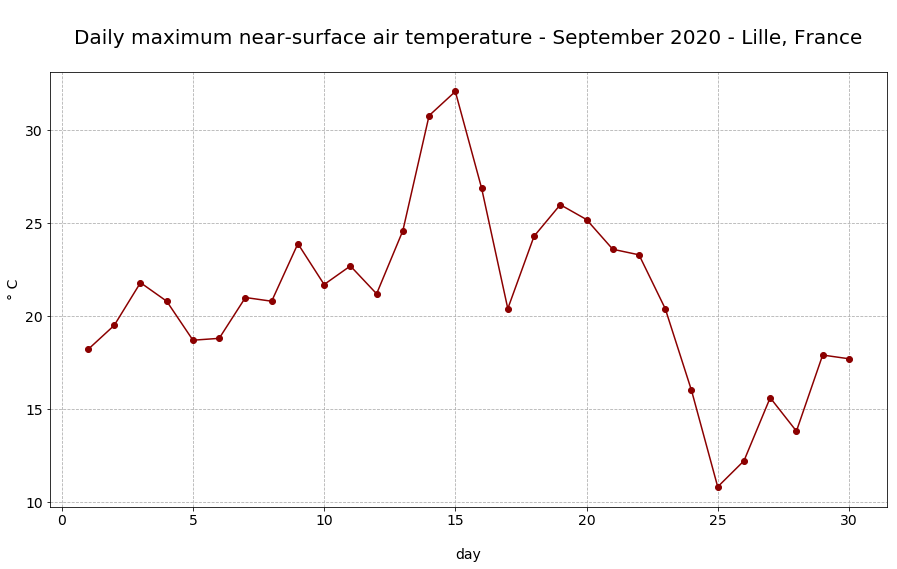

In [15]:
# Initiate a figure
fig = plt.figure(figsize=(15,8))
ax = plt.subplot()

# Define the plotting function
ax.plot(x, y_2020, 'bo-', color='darkred')

# Customize the title and axes lables
ax.set_title('\n'+era5_t2m_max_2020_lille.long_name+'\n', fontsize=20)
ax.set_ylabel(era5_t2m_max_2020_lille.units, fontsize=14)
ax.set_xlabel('\nday', fontsize=14)

# Customize the fontsize of the axes tickes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a gridline to the plot
ax.grid(linestyle='--')

<br>

Above, you see that on 15 September 2020, Lille experienced the highest temperature for September 2020. If you want to select the maximum value of the data array `era5_t2m_max_2020_lille`, you can simply apply the function `max()`. If you additionally add `values` to it, you can extract the data value from the `xarray.DataArray` structure.

You see, that on 15 September 2020, the maximum temperature was 32.1 degrees Celsius.

In [16]:
era5_t2m_max_2020_lille.max().values

array(32.05613, dtype=float32)

<br>

The question that remains open is whether temperatures above 30 degrees Celsius in September are normal for Lille or whether the 15 September 2020 was an extreme. For this to find out, let us compare the maximum daily temperatures for September 2020 with the long term average of the same region and for the same period. 

<br>

## <a id='longterm_averages'></a>3. Calculation of the long term average of daily maximum near-surface air temperature over northern France for September


The next step is compute the average maximum temperature for each day in September for Lille. To do this, we can compute the average and standard deviation of the maximum air temperature for each day, based on the period 1979 to 2019. This gives us a better understanding of the range of maximum temperatures expected in average. This helps us also to compare the values of September 2020 with the longterm average.

The first step is to select the hourly air temperature values for September for the years from 1979 to 2019 from the data array `era5_t2m_hourly_lille`. You can use the function `.loc()` to select the range between two years. The result is a data array with `time` as dimension and 29520 entries.

In [17]:
era5_t2m_hourly_lille_1979_2019 = era5_t2m_hourly_lille.loc['1979':'2019']
era5_t2m_hourly_lille_1979_2019

<xarray.DataArray 't2m' (time: 29520)>
array([16.354841, 15.944101, 15.631228, ..., 14.849879, 14.405537,
       14.485022], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-09-01 ... 2019-09-30T23:00:00
Attributes:
    units:      ° C
    long_name:  2 metre temperature

<br>

The next step is to `downsample` the hourly air temperature data to daily maximum air temperature values. You can apply the function `resample()` and specify `time='1D'`, which groups the hourly data into individual days (n=1230). If you add the function `max()` after the resampling, the maximum value of each group (of each day) is selected. The resulting array contains for each day in September for the period 1979 to 2019 the maximum near-surface air temperature.

In [18]:
era5_t2m_daily_max_lille_1979_2019 = era5_t2m_hourly_lille_1979_2019.resample(time='1D').max().dropna('time')
era5_t2m_daily_max_lille_1979_2019

<xarray.DataArray 't2m' (time: 1230)>
array([26.97958 , 19.275888, 16.507517, ..., 17.258278, 17.842402,
       17.462774], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-09-01 1979-09-02 ... 2019-09-30

<br>

The overall aim is to compute the average maximum air temperature for each day in September. This means we create the climatology of the maximum air temperature for each day in September for Lille. You can use the function `groupby('time.day')`, which groups the values into day groups. If you apply the function `mean()` afterwards, you compute the average value of all the maximum air temperatures in September from 1979 to 2019. The resulting data array has the dimension `day` with 30 entries, one for each day in September.

In [19]:
era5_t2m_daily_max_lille = era5_t2m_daily_max_lille_1979_2019.groupby('time.day').mean()
era5_t2m_daily_max_lille

<xarray.DataArray 't2m' (day: 30)>
array([19.673044, 20.123386, 20.117393, 19.801262, 20.20711 , 19.693546,
       19.334984, 19.768057, 19.811024, 20.005922, 19.52921 , 19.193317,
       18.400814, 18.402147, 18.317297, 18.285757, 18.43752 , 18.488266,
       18.850027, 18.659428, 19.110586, 18.228884, 17.754591, 17.520355,
       17.44802 , 17.714842, 17.592215, 17.69666 , 17.624634, 17.318457],
      dtype=float32)
Coordinates:
  * day      (day) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30

<br>

As a final step before we can visualize the climatology of daily maximum air temperature in September for Lille is to compute the standard deviation of the maximum air temperature values, too. The standard deviation gives us information about how strong the maximum air temperature values varied during the 40 year period. Instead of the function `mean()`, you apply now the aggregator function `std()`, which calculates the standard deviation of maximum air temperature for each day in September.

In [20]:
era5_t2m_daily_max_lille_std = era5_t2m_daily_max_lille_1979_2019.groupby('time.day').std()
era5_t2m_daily_max_lille_std

<xarray.DataArray 't2m' (day: 30)>
array([2.5926123, 2.695584 , 3.5946493, 3.5339577, 3.5856972, 2.682263 ,
       3.2517653, 3.3053384, 3.1609943, 3.5296593, 3.634351 , 3.426179 ,
       3.328773 , 2.8561528, 3.1814487, 3.4515483, 3.8148708, 3.7795186,
       3.2282667, 3.3358314, 3.5368457, 3.3497372, 2.7710614, 2.9304419,
       2.5464516, 2.7858098, 2.7777627, 2.9211307, 2.7422786, 2.4489772],
      dtype=float32)
Coordinates:
  * day      (day) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30

<br>

Now, we can prepare the variables for plotting. We want to visualize the average maximum air temperature for each day in September for Lille, but also the plus and minus standard deviation. This gives us an idea of the expected range of maximum daily temperatures in Lille in average.

We define three y-variables:
* `y1`: time-series of average maximum daily air temperature values in Lille
* `y2`: time-series of average maximum daily air temperature values PLUS the standard deviation, to indicate the threshold on the top of the range
* `y3`: time-series of average maximum daily air temperature values MINUS the standard deviation, to indicate the threshold on the bottom of the range

In [21]:
y1 = era5_t2m_daily_max_lille[:]
y2 = era5_t2m_daily_max_lille[:] + era5_t2m_daily_max_lille_std[:]
y3 = era5_t2m_daily_max_lille[:] - era5_t2m_daily_max_lille_std[:]

y1, y2, y3

(<xarray.DataArray 't2m' (day: 30)>
 array([19.673044, 20.123386, 20.117393, 19.801262, 20.20711 , 19.693546,
        19.334984, 19.768057, 19.811024, 20.005922, 19.52921 , 19.193317,
        18.400814, 18.402147, 18.317297, 18.285757, 18.43752 , 18.488266,
        18.850027, 18.659428, 19.110586, 18.228884, 17.754591, 17.520355,
        17.44802 , 17.714842, 17.592215, 17.69666 , 17.624634, 17.318457],
       dtype=float32)
 Coordinates:
   * day      (day) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30,
 <xarray.DataArray 't2m' (day: 30)>
 array([22.265656, 22.81897 , 23.712044, 23.33522 , 23.792807, 22.375809,
        22.58675 , 23.073395, 22.972017, 23.535582, 23.16356 , 22.619495,
        21.729588, 21.2583  , 21.498745, 21.737305, 22.25239 , 22.267784,
        22.078293, 21.995258, 22.647432, 21.57862 , 20.525652, 20.450798,
        19.994473, 20.500652, 20.369978, 20.61779 , 20.366913, 19.767433],
       dtype=float32)
 Coordinates:
   * day      (day) int64 1 2 3 

<br>

Now, we can visualize the climatology of the maximum daily air temperature for Lille, France based on the reference period 1979 to 2019. The matplotlib code for visualising the climatology can be split into four main parts:

* **1. Plot initiation**: Define size of the plot and initiate a subplot area with `plt.subplot()`

* **2. Plotting functions**: 
  * `plot()`: Time-series plot of average maximum 2m air temperature
  * `fill_between()`: colorized area indicating the minimum and maximum range of maximum 2m air temperature


* **3. Set labels and title**: Set name of x- and y-axis as well as title of the plot

* **4. Customize features**: Apply additional features to customized the style of the plot, e.g. size of x- and y-ticks or add gridlines

(array([12., 14., 16., 18., 20., 22., 24., 26., 28.]),
 <a list of 9 Text yticklabel objects>)

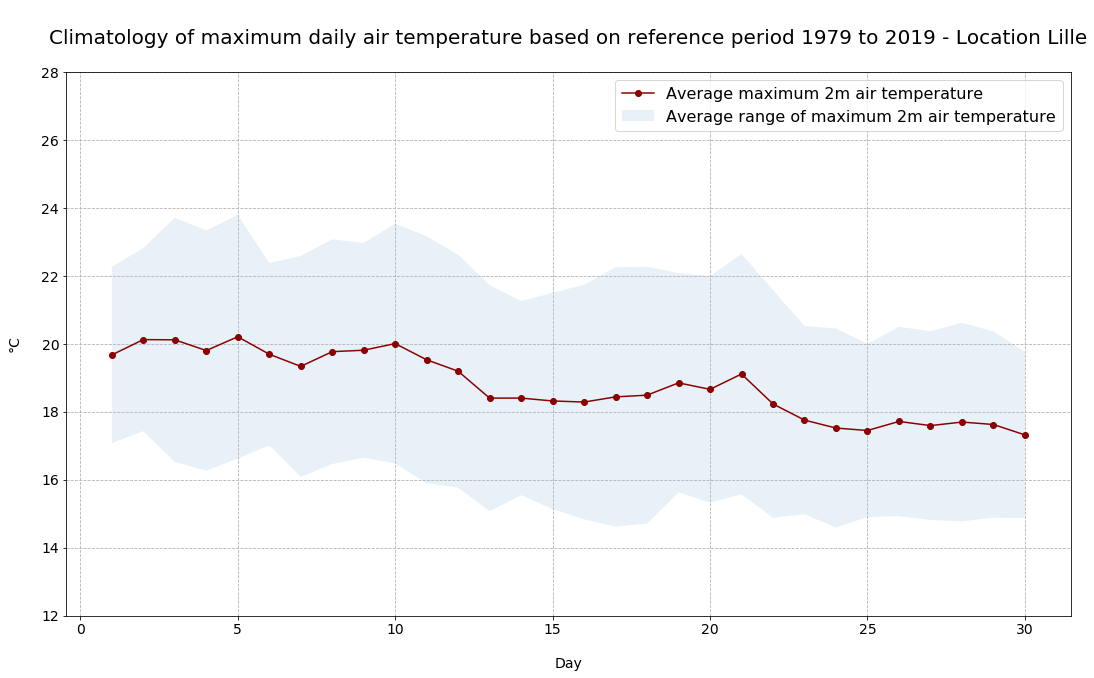

In [22]:
# Initiate the plot
fig = plt.figure(figsize=(18,10))
ax = plt.subplot()

# Plot mean maximum temperature time-series and +/- sd as filled range
ax.plot(era5_t2m_daily_max_lille.day[:], y1, 'bo-', color='darkred', label='Average maximum 2m air temperature')
ax.fill_between(era5_t2m_daily_max_lille.day[:], y2, y3, alpha=0.1, label='Average range of maximum 2m air temperature')
#ax.plot(era5_t2m_daily_max_lille.day[:-1], y_2020, 'bo-', color='grey')

# Set axes labels and titles and customize legend
ax.set_title('\nClimatology of maximum daily air temperature based on reference period 1979 to 2019 - Location Lille\n', fontsize=20, )
ax.set_ylabel('°C\n', fontsize=14)
ax.set_xlabel('\nDay', fontsize=14)
plt.legend(fontsize=16, loc=1)

# Customize limits for y-axis, grid and fontsize of x- and y-tickes
ax.set_ylim(12,28)
ax.grid(linestyle='--')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

<be>

Above, you see that the mean maximum daily 2m air temperature in Lille in September ranges between 15 and around 24 degrees Celsius. Additionally, you see that the 2m air temperature has in average a decreasing trend in the course of September.

For comparison, we can now add the time-series of daily maximum air temperature in Lille in September 2020 to the plot above.
For this, the following adjustments to the visualisation code have to be made:
* add an additional line plot with the function `plot()` representing the data array `y_2020`
* increase the minimum and maximum limits of the y-axis

(array([10., 15., 20., 25., 30., 35.]), <a list of 6 Text yticklabel objects>)

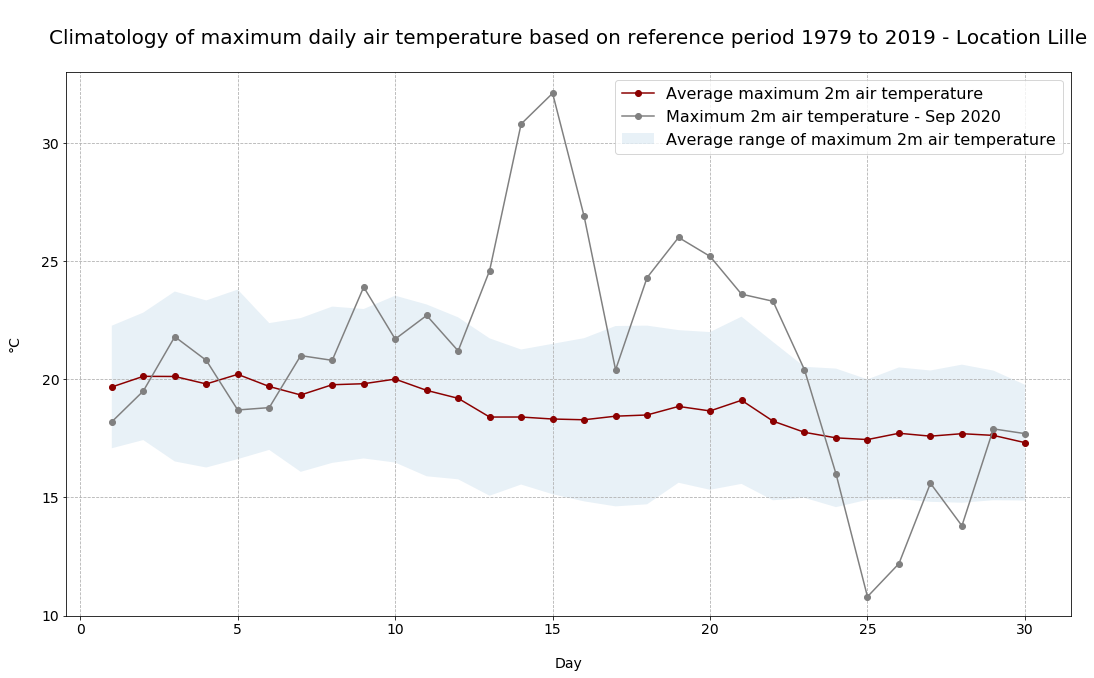

In [23]:
# Initiate the plot
fig = plt.figure(figsize=(18,10))
ax = plt.subplot()

# Plot mean maximum temperature time-series and +/- sd as filled range
ax.plot(era5_t2m_daily_max_lille.day[:], y1, 'bo-', color='darkred', label='Average maximum 2m air temperature')
ax.fill_between(era5_t2m_daily_max_lille.day[:], y2, y3, alpha=0.1, label='Average range of maximum 2m air temperature')

# Add 2020 time-series
ax.plot(era5_t2m_daily_max_lille.day[:], y_2020, 'bo-', color='grey', label= 'Maximum 2m air temperature - Sep 2020')

# Set axes labels and titles and customize legend
ax.set_title('\nClimatology of maximum daily air temperature based on reference period 1979 to 2019 - Location Lille\n', fontsize=20, )
ax.set_ylabel('°C\n', fontsize=14)
ax.set_xlabel('\nDay', fontsize=14)
plt.legend(fontsize=16, loc=1)

# Customize limits for y-axis, grid and fontsize of x- and y-tickes
ax.set_ylim(10,33)
ax.grid(linestyle='--')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

<br>

This visual comparison above shows that the maximum 2m air temperature in September 2020 had an unusual behaviour during two periods: 
* mid of September, where maximum 2m air temperature values were way above the upper average range and 
* end of September, where some days were way below the lower average range of maximum 2m air temperatures.

As a next step, let us analyse the probability distribution of the maximum temperatures in Lille for 15 September during the reference period 1979 to 2019.

<br>

## <a id='probability_distribution'></a>4. Analyse the probability distribution of daily maximum 2m air temperature

We will now have a closer look at the probability distribution of maximum temperatures for 15 September during the reference period 1979 to 2019. To do this, we will first select only the maximum temperature for 15 September for each year in the time series of the data array `era5_t2m_daily_max_lille_1979_2019`. You can do this by specifying `[14::30]`, which selects the temperature value of index 14 and after that every 30th element in the array. The result is a data array with 41 entries.

In [24]:
era5_t2m_max_1509 = era5_t2m_daily_max_lille_1979_2019[14::30]
era5_t2m_max_1509

<xarray.DataArray 't2m' (time: 41)>
array([15.401128 , 18.87491  , 19.725744 , 26.615425 , 18.491583 ,
       15.580325 , 16.026005 , 12.536291 , 17.65822  , 15.655    ,
       18.488207 , 16.989294 , 20.443825 , 17.852777 , 15.143686 ,
       13.520054 , 17.074465 , 16.954762 , 18.492018 , 15.5621395,
       16.629015 , 23.039682 , 15.84534  , 19.784187 , 23.290943 ,
       16.227253 , 19.582155 , 24.639961 , 19.796991 , 14.767342 ,
       17.505743 , 16.4195   , 19.132103 , 19.379356 , 16.433578 ,
       22.327822 , 16.752974 , 24.089746 , 14.548633 , 19.49328  ,
       24.23767  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-09-15 1980-09-15 ... 2019-09-15

<br>

The next step is to visualize the temperature range of the maximum temperature values in Lille on 15 September with the help of a histogram. The histogram represents the frequency distribution of maximum temperatures of 15 September in Lille.

Below, we create a histogram plot with the xarray function `plot.hist()`. This built-in function combines two operations: (i) it first computes the frequency distribution and (ii) plots the values as histogram in a second step. With the `bins` kwarg, you can specify the groups the data shall be grouped in, e.g. `np.arange(10,32,1)` creates groups of 1 degree Celsius from 10 degrees Celsius to 32 degrees Celsius.

**Note:** you can create an `axes` object with `plt.subplot()` and pass it on as kwarg to the plotting function. In this way, you can customize the title and axes labels of your plot.

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <a list of 10 Text yticklabel objects>)

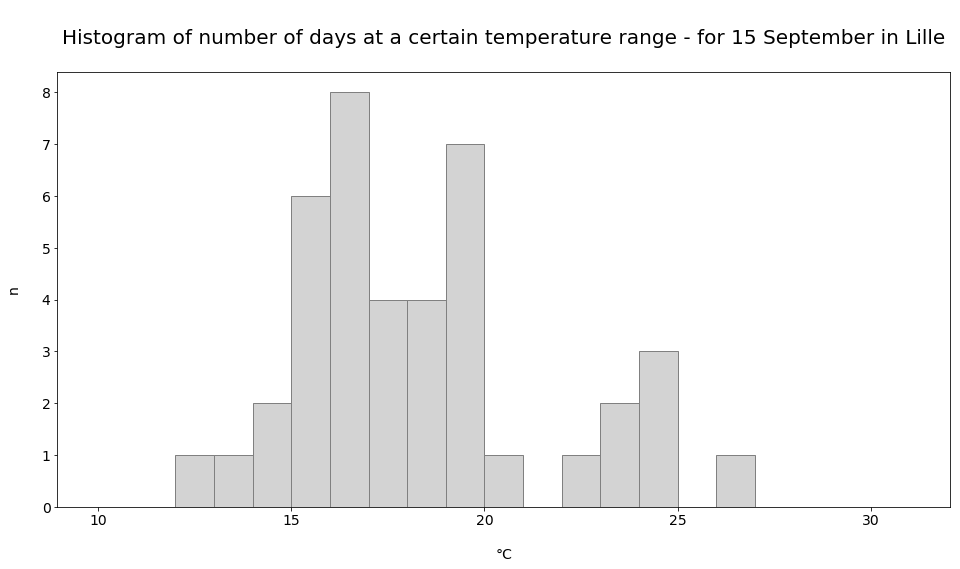

In [25]:
# Initiate the figure and axes object
fig = plt.figure(figsize=(16,8))
ax = plt.subplot()

# Plot the data as histogram and provide the axes object as keyword argument
era5_t2m_max_1509.plot.hist(ax=ax,
                           color='lightgrey', 
                            ec='grey',
                           bins=np.arange(10,32,1))

# Customize title and axes lables of the plot with the help of the axes object
ax.set_title('\nHistogram of number of days at a certain temperature range - for 15 September in Lille\n', fontsize=20)
ax.set_xlabel('\n°C', fontsize=14)
ax.set_ylabel('n\n', fontsize=14)

# Increase the fontsize of the x- and y-ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

<br>

Look at the range of maximum temperatures in Lille for 15 September in the period from 1979 to 2019. Has the temperature in this period ever exceeded that of 15 September 2020? In order to increase the number of samples, let us plot the histogram of maximum temperatures in Lille on 15 September again, but let us increase the sample by plus or minus three days. This increases the number of samples by a factor of seven.

To do this, we first need to produce an index that takes the maximum 2m air temperature values from 12 to 18 September (15 September +/- three days) from every year in the time series. The first step is to initiate three numpy arrays:
* `years`: with the number of years [0:40]
* `days_in_sep`: index values of day range [11:17]
* `index`: empty numpy array with 287 (41 years * 7) entries


In [26]:
years = np.arange(41)
days_in_sep = np.arange(11,18)
index = np.zeros(287)

years, days_in_sep, index

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]),
 array([11, 12, 13, 14, 15, 16, 17]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

<br>

In a next step, we then loop through each entry of the `years` array and fill the empty `index` array year by year with the correct indices of the day ranges for each year. The resulting array contains the index values of interest.

In [27]:
for i in years:
    index[i*7:(i*7)+7] = days_in_sep + (i*30)
index = index.astype(int)
index

array([  11,   12,   13,   14,   15,   16,   17,   41,   42,   43,   44,
         45,   46,   47,   71,   72,   73,   74,   75,   76,   77,  101,
        102,  103,  104,  105,  106,  107,  131,  132,  133,  134,  135,
        136,  137,  161,  162,  163,  164,  165,  166,  167,  191,  192,
        193,  194,  195,  196,  197,  221,  222,  223,  224,  225,  226,
        227,  251,  252,  253,  254,  255,  256,  257,  281,  282,  283,
        284,  285,  286,  287,  311,  312,  313,  314,  315,  316,  317,
        341,  342,  343,  344,  345,  346,  347,  371,  372,  373,  374,
        375,  376,  377,  401,  402,  403,  404,  405,  406,  407,  431,
        432,  433,  434,  435,  436,  437,  461,  462,  463,  464,  465,
        466,  467,  491,  492,  493,  494,  495,  496,  497,  521,  522,
        523,  524,  525,  526,  527,  551,  552,  553,  554,  555,  556,
        557,  581,  582,  583,  584,  585,  586,  587,  611,  612,  613,
        614,  615,  616,  617,  641,  642,  643,  6

<br>

In a last step, we use the `index` array and filter the data array `era5_t2m_daily_max_lille_1979_2019`, which contains the maximum daily temperatures in Lille in September from 1979 to 2019. The resulting object is a numpy array with 287 values representing the maximum 2m air temperature in Lille between 12 and 18 September for each year from 1979 to 2019.

In [28]:
era5_t2m_max_7day_range = era5_t2m_daily_max_lille_1979_2019.values[index]
era5_t2m_max_7day_range

array([18.84463  , 18.040886 , 16.744371 , 15.401128 , 16.782759 ,
       20.988625 , 18.823072 , 17.154238 , 16.775925 , 16.974852 ,
       18.87491  , 20.217064 , 18.821701 , 19.560802 , 20.21428  ,
       15.994635 , 17.404085 , 19.725744 , 17.880407 , 19.315668 ,
       17.473703 , 23.482063 , 20.697124 , 22.347794 , 26.615425 ,
       26.507109 , 26.383745 , 25.349957 , 12.490958 , 13.478952 ,
       16.129128 , 18.491583 , 14.588529 , 15.226167 , 16.267094 ,
       18.69715  , 20.718056 , 17.341751 , 15.580325 , 16.820135 ,
       15.775852 , 15.745896 , 25.069956 , 17.300789 , 16.242996 ,
       16.026005 , 15.673928 , 19.060614 , 21.193481 , 12.631532 ,
       16.23395  , 17.656736 , 12.536291 , 11.8769   , 11.035566 ,
       13.871915 , 23.460102 , 19.66532  , 18.801283 , 17.65822  ,
       21.472218 , 25.23311  , 21.76852  , 16.114643 , 12.729755 ,
       14.786764 , 15.655    , 14.325996 , 15.091755 , 15.717449 ,
       19.052162 , 16.902294 , 17.241371 , 18.488207 , 20.9401

<br>

The last step is to visualize again the frequency distribution, but now we take the array with the larger sample. This time, as the `era5_t2m_max_7day_range` object is a numpy array, we can use the `hist()` function of the matplotlib library. You can also specify the `bins` kwarg to define the groups of temperature ranges.

The other keyword arguments are the same as before and help to customize the histogram, e.g. to set title and labels for x- and y-axes.

(array([ 0., 10., 20., 30., 40., 50.]), <a list of 6 Text yticklabel objects>)

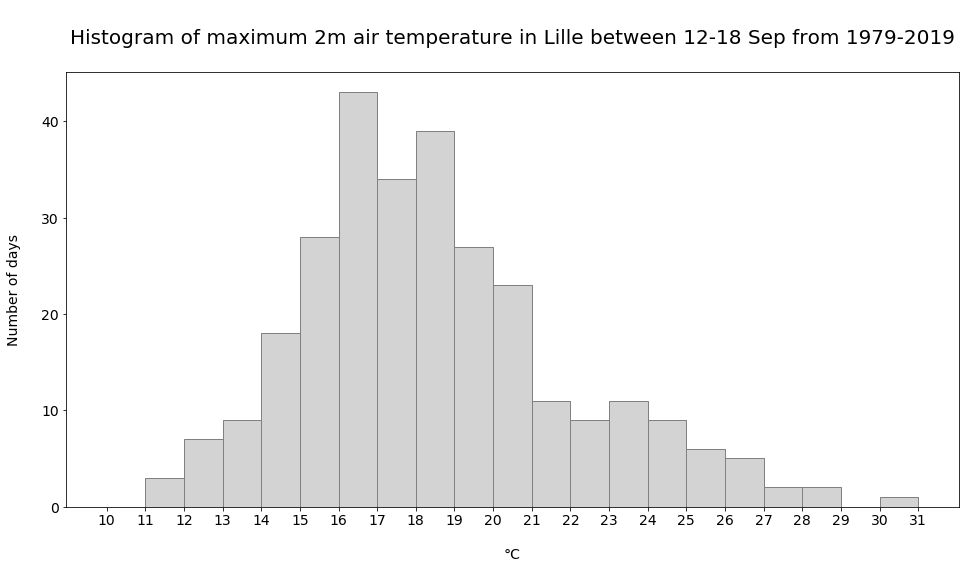

In [29]:
# Initiate the figure
plt.figure(figsize=(16,8))

# Apply the `hist()` function to create and visualize the histogram
plt.hist(era5_t2m_max_7day_range, 
         bins = np.arange(10,32,1),
        color='lightgrey',
        ec='grey')

# Customize the title and x- and y-axes labels
plt.title("\nHistogram of maximum 2m air temperature in Lille between 12-18 Sep from 1979-2019\n", fontsize=20)
plt.xlabel("\n°C", fontsize=14)
plt.ylabel("Number of days\n", fontsize=14)

# Adjust fontsize of x- and y-axes ticks
plt.xticks(np.arange(10,32,1), fontsize=14)
plt.yticks(fontsize=14)

In the histogram above, you see that even if we take an increased sample covering a wider temporal range, the maximum daily temperature still never reached that of 15 September 2020.

<hr>

<p><img src='./img/copernicus_logo.png' align='right' alt='Logo EU Copernicus' width='20%'></img></p>
<br><br><br><br><br>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>